In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from typing import Optional, Sequence, Dict, Any
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# #MinMax Scaling
# #FEATURE–TARGET RELATIONSHIP CHECKS
# num_features = df_model.select_dtypes(include='number').columns.drop('Valve')

# scaler = MinMaxScaler()
# scaled_cols = num_features  # all numeric features except target

# df_model[scaled_cols] = scaler.fit_transform(df_model[scaled_cols])

In [16]:
# --------- CONFIG---------
SETPOINT_TEMP = 22.0      # desired indoor temp (°C)
TARGET_HUMID  = 50.0      # desired indoor humidity (%)
ACTION_RANGE  = (0.0, 100.0)  # valve absolute % control

# Reward weights (tune later)
REWARD_WEIGHTS = {
    "imitation": 1.0,   # closeness to expert/logged Valve (imitation term)
    "energy":    0.2,   # cost for using large valve openings
    "smooth":    0.05,  # penalty for rapid valve changes
    "comfort":   0.0,   # if >0, adds penalty for |RaTemp - setpoint|
}

# Suggested observation features (auto-filtered to what's present in your df)
SUGGESTED_OBS = [
    "RaTemp", "SaTemp", "RaHumidity", "ThermEnergy", # core equipment
    "main.temp", "main.humidity", "wind.speed", "clouds.all", # weather
    "hour_sin", "hour_cos", "minute_sin", "minute_cos", "dayofweek", "is_weekend", # time encodings
    "Occp", # occupancy
    "delta_supply_return", "delta_outdoor_indoor", "delta_humidity","Valve_lag_1", "RaTemp_lag_1", "SaTemp_lag_1", 
    "RaHumidity_lag_1" # basic engineered deltas/lags
]
# -------------------------------------------


def build_observation_matrix(df: pd.DataFrame, obs_features: list, fit_scaler: bool = True):
    """Return (X, scaler). X is NumPy array of observations (unscaled if fit_scaler=False and scaler=None)."""
    obs_cols = [c for c in obs_features if c in df.columns]
    if len(obs_cols) == 0:
        raise ValueError("None of the requested observation features were found in the dataframe.")

    X_raw = df[obs_cols].astype(float).fillna(0.0).values

    scaler = None
    if fit_scaler:
        scaler = StandardScaler()
        scaler.fit(X_raw)
        X = scaler.transform(X_raw).astype(np.float32)
    else:
        X = X_raw.astype(np.float32)

    return X, scaler, obs_cols


class HVACEnv(gym.Env):
    """
    Step 2 + Step 3: Custom HVAC environment with embedded reward.
    - Observations: vector of selected, (optionally) scaled features
    - Action: absolute valve position in [ACTION_RANGE]
    - Reward: imitation (to logged Valve) + energy + smoothness (+ optional comfort)
    Note: This is an 'offline/logged-dynamics' env — states follow the dataset timeline.
    """

    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        obs_features: list,
        scaler: StandardScaler = None,
        action_low: float = ACTION_RANGE[0],
        action_high: float = ACTION_RANGE[1],
        reward_weights: dict = None,
        setpoint: float = SETPOINT_TEMP,
        target_humidity: float = TARGET_HUMID,
        episode_length: int | None = None,
        start_index: int = 0
    ):
        super().__init__()

        self.df = df.reset_index(drop=True).copy()
        self.setpoint = float(setpoint)
        self.target_humidity = float(target_humidity)
        self.start_index = int(start_index)
        self.reward_weights = reward_weights or REWARD_WEIGHTS.copy()

        # Build observation matrix and keep column list
        self.X, self.scaler, self.obs_cols = build_observation_matrix(self.df, obs_features, fit_scaler=(scaler is None))
        if scaler is not None:
            self.scaler = scaler
            self.X = self.scaler.transform(self.df[self.obs_cols].astype(float).fillna(0.0).values).astype(np.float32)

        # Target/expert valve from data (for imitation)
        if "Valve" not in self.df.columns:
            raise ValueError("'Valve' column is required in df for imitation reward.")
        self.y_valve = self.df["Valve"].astype(float).values  # expert/logged valve

        # Action space: absolute valve percentage
        self.action_low = float(action_low)
        self.action_high = float(action_high)
        self.action_space = spaces.Box(low=self.action_low, high=self.action_high, shape=(1,), dtype=np.float32)

        # Observation space: vector length = len(obs_cols)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(self.obs_cols),), dtype=np.float32
        )

        # Episode settings
        self.episode_length = int(episode_length) if episode_length is not None else (len(self.df) - self.start_index)
        self.current_step = None
        self.prev_action = None  # for smoothness penalty

    def reset(self, *, seed: int | None = None, options: dict | None = None):
        super().reset(seed=seed)
        self.current_step = self.start_index
        self.prev_action = self.y_valve[self.current_step]  # initialize with logged valve (reasonable starting point)
        obs = self._get_obs(self.current_step)
        return obs, {}

    def step(self, action):
        # 1) clip action
        a = float(np.clip(action[0], self.action_low, self.action_high))

        # 2) compute reward at current index (uses dataset values + action)
        r = self._compute_reward(idx=self.current_step, action=a)

        # 3) advance time
        self.current_step += 1
        done = self.current_step >= (self.start_index + self.episode_length) or self.current_step >= len(self.df)

        # 4) next obs
        next_idx = min(self.current_step, len(self.df) - 1)
        obs = self._get_obs(next_idx)

        # 5) update prev_action
        self.prev_action = a

        return obs, float(r), bool(done), False, {}

    # ---------- helpers ----------

    def _get_obs(self, idx: int) -> np.ndarray:
        return self.X[idx].astype(np.float32)

    def _compute_reward(self, idx: int, action: float) -> float:
        """
        Reward = - [ w_im * imitation + w_energy * energy + w_smooth * smooth (+ w_comfort * comfort) ]
        Where:
          imitation = |action - expert_valve| / 100
          energy    = (action / 100)^2
          smooth    = |action - prev_action| / 100
          comfort   = |RaTemp - setpoint|  (OPTIONAL, doesn't depend on action)
        """
        w = self.reward_weights

        expert_valve = self.y_valve[idx]
        imitation = abs(action - expert_valve) / 100.0

        energy = (action / 100.0) ** 2

        if self.prev_action is None:
            smooth = 0.0
        else:
            smooth = abs(action - self.prev_action) / 100.0

        comfort = 0.0
        if w.get("comfort", 0.0) > 0.0:
            ra_temp = float(self.df.at[idx, "RaTemp"]) if "RaTemp" in self.df.columns else self.setpoint
            comfort = abs(ra_temp - self.setpoint)

        penalty = (
            w.get("imitation", 1.0) * imitation +
            w.get("energy", 0.2) * energy +
            w.get("smooth", 0.05) * smooth +
            w.get("comfort", 0.0) * comfort
        )

        # Negative penalty → higher reward for smaller penalty
        reward = -penalty

        # Clip reward to a stable range
        return float(np.clip(reward, -10.0, 0.0))

    def render(self):
        idx = min(self.current_step, len(self.df) - 1)
        row = self.df.iloc[idx]
        print(f"t={idx} | RaTemp={row.get('RaTemp', np.nan):.2f} | Hum={row.get('RaHumidity', np.nan):.1f} | "
              f"ExpertValve={self.y_valve[idx]:.1f} | PrevAct={self.prev_action if self.prev_action is not None else np.nan:.1f}")

    def close(self):
        pass


# ---------- Factory function to build env from dataframe ----------
def make_hvac_env_from_df(df_preprocessed: pd.DataFrame, obs_feature_list: list | None = None):
    """
    Pass your dataframe from Step 1 here (after preprocessing & feature engineering).
    Returns (env, scaler, obs_cols) ready for Step 4 (PPO training).
    """
    obs_list = obs_feature_list or SUGGESTED_OBS
    X, scaler, obs_cols = build_observation_matrix(df_preprocessed, obs_list, fit_scaler=True)

    # The env will rebuild X internally with the same scaler, so we just pass df & scaler.
    env = HVACEnv(
        df=df_preprocessed,
        obs_features=obs_cols,
        scaler=scaler,
        action_low=ACTION_RANGE[0],
        action_high=ACTION_RANGE[1],
        reward_weights=REWARD_WEIGHTS,
        setpoint=SETPOINT_TEMP,
        target_humidity=TARGET_HUMID,
        episode_length=None,
        start_index=0
    )
    return env, scaler, obs_cols


# Initiating PPO Model

In [17]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

In [18]:
df_preprocessed = pd.read_csv("./files/final_feature_df.csv")

In [19]:
# INITIATE PPO MODEL

# Wrap your custom environment with DummyVecEnv (SB3 requirement)
env = DummyVecEnv([lambda: HVACEnv(df_preprocessed, SUGGESTED_OBS)])   # HVACEnv is environment class

# Initialize PPO model
model = PPO(
    policy="MlpPolicy",       # Multilayer Perceptron policy (good for tabular/numerical features)
    env=env,
    learning_rate=3e-4,       # typical PPO LR
    n_steps=2048,             # PPO rollout steps before update
    batch_size=64,            # minibatch size
    n_epochs=10,              # PPO optimization epochs
    gamma=0.99,               # discount factor for rewards
    gae_lambda=0.95,          # GAE parameter
    clip_range=0.2,           # PPO clipping
    verbose=1
)



/home/aaqil/miniconda3/envs/proj/lib/python3.10/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Using cpu device


In [20]:
# STEP 5: TRAIN PPO MODEL

# Train the PPO model
model.learn(total_timesteps=100000) 

# Save the trained model
model.save("ppo_hvac_model")

print("PPO Model training completed and saved.")

-----------------------------
| time/              |      |
|    fps             | 949  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 619          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0051322198 |
|    clip_fraction        | 0.0193       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | -0.0427      |
|    learning_rate        | 0.0003       |
|    loss                 | 5.94         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00309     |
|    std                  | 1.02         |
|    value_loss           | 50.1         |
----------------

------------------------------------------
| time/                   |              |
|    fps                  | 524          |
|    iterations           | 12           |
|    time_elapsed         | 46           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0056889886 |
|    clip_fraction        | 0.0416       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0.852        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.82         |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00515     |
|    std                  | 0.985        |
|    value_loss           | 7.87         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 522          |
|    iterations           | 13           |
|    time_e

-----------------------------------------
| time/                   |             |
|    fps                  | 518         |
|    iterations           | 23          |
|    time_elapsed         | 90          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.004981003 |
|    clip_fraction        | 0.0371      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.33        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00581    |
|    std                  | 0.933       |
|    value_loss           | 4.04        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 517          |
|    iterations           | 24           |
|    time_elapsed         | 94

-----------------------------------------
| time/                   |             |
|    fps                  | 499         |
|    iterations           | 34          |
|    time_elapsed         | 139         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.004653031 |
|    clip_fraction        | 0.0445      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.818       |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.00728    |
|    std                  | 0.856       |
|    value_loss           | 2.52        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 494         |
|    iterations           | 35          |
|    time_elapsed         | 144   

------------------------------------------
| time/                   |              |
|    fps                  | 494          |
|    iterations           | 45           |
|    time_elapsed         | 186          |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0055743414 |
|    clip_fraction        | 0.0496       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.18        |
|    explained_variance   | 0.935        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.15         |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.00822     |
|    std                  | 0.789        |
|    value_loss           | 4.46         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 494          |
|    iterations           | 46           |
|    time_e

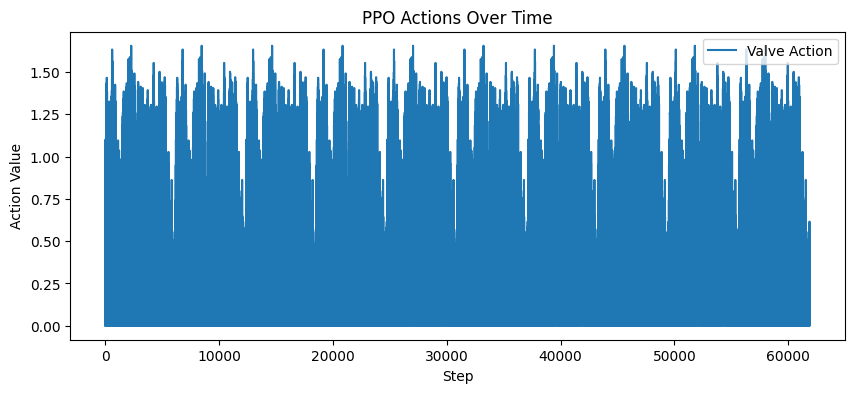

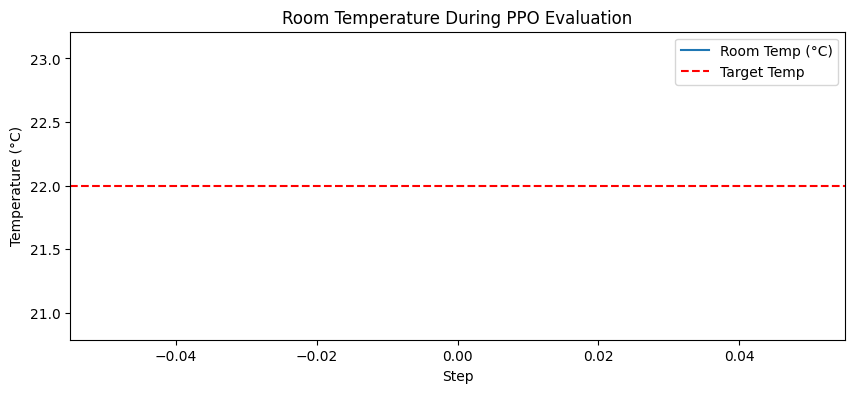

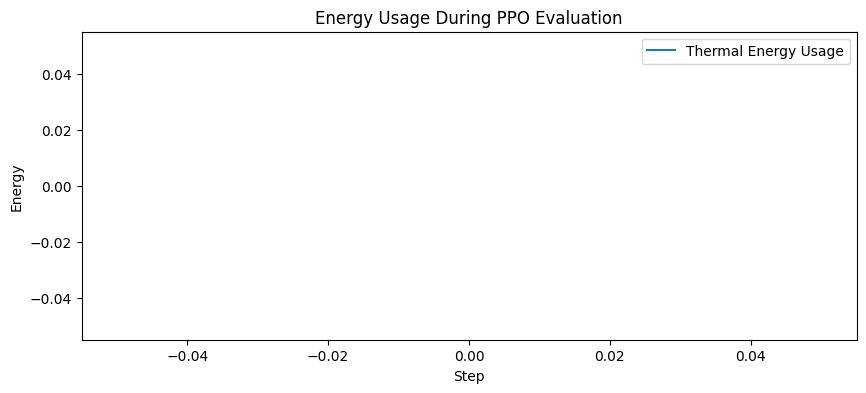

Avg Reward per Episode: -3351.66
Max Reward in an Episode: -3351.66
Min Reward in an Episode: -3351.66


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# STEP 6: Evaluate PPO performance over the time (Evaluation phase)

# Load trained model
from stable_baselines3 import PPO

model = PPO.load("ppo_hvac_model")  # replace with your saved model filename

# Run evaluation
obs = env.reset()
done = False
rewards = []
actions = []
temps = []
energy_use = []
episode_rewards = []
episode_count = 0

while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)

    rewards.append(reward)
    actions.append(action)
#     temps.append(info.get("RaTemp", np.nan))  # assuming env.info gives RaTemp
#     energy_use.append(info.get("ThermEnergy", np.nan))
    # Handle vectorized env info
    info_dict = info[0] if isinstance(info, list) else info

    temps.append(info_dict.get("RaTemp", np.nan))
    energy_use.append(info_dict.get("ThermEnergy", np.nan))

    if done:
        episode_count += 1
        episode_rewards.append(np.sum(rewards))
        obs = env.reset()
        rewards = []

        # Stop after evaluating certain number of episodes
        if episode_count >= 10:  # evaluate for 10 episodes
            break

# Convert to DataFrame for plotting
eval_df = pd.DataFrame({
    "Action": actions,
    "RaTemp": temps,
    "EnergyUse": energy_use
})

# ---- Plot 1: Actions over time ----
plt.figure(figsize=(10,4))
plt.plot(eval_df["Action"], label="Valve Action")
plt.xlabel("Step")
plt.ylabel("Action Value")
plt.title("PPO Actions Over Time")
plt.legend()
plt.show()

# ---- Plot 2: Room Temperature over time ----
plt.figure(figsize=(10,4))
plt.plot(eval_df["RaTemp"], label="Room Temp (°C)")
plt.axhline(y=22, color="r", linestyle="--", label="Target Temp")
plt.xlabel("Step")
plt.ylabel("Temperature (°C)")
plt.title("Room Temperature During PPO Evaluation")
plt.legend()
plt.show()

# ---- Plot 3: Energy Usage over time ----
plt.figure(figsize=(10,4))
plt.plot(eval_df["EnergyUse"], label="Thermal Energy Usage")
plt.xlabel("Step")
plt.ylabel("Energy")
plt.title("Energy Usage During PPO Evaluation")
plt.legend()
plt.show()

# ---- Print episode-level metrics ----
print(f"Avg Reward per Episode: {np.mean(episode_rewards):.2f}")
print(f"Max Reward in an Episode: {np.max(episode_rewards):.2f}")
print(f"Min Reward in an Episode: {np.min(episode_rewards):.2f}")
